# Grover's Search Algorithm

<blockquote style="background:rgba(59,130,246,.08);border-left:6px solid #3b82f6;padding:1rem 1.25rem;margin:.5rem 0;">
<strong>Grover’s search algorithm</strong>, introduced by Lov Grover in 1996   <span id="cite-Gro96"></span>
  [<a href="#ref-Gro96">1</a>], is one of the canonical quantum algorithms. It provides a quadratic speedup for searching an unstructured database, and is often considered alongside Shor’s algorithm as a cornerstone of quantum computing.
  <br>
  <ul>
    <li> <strong> Input: </strong> A Boolean function (oracle) $f: \{0,1\}^n \rightarrow \{0,1\}$ marking "solutions" among $N=2^n$ possible items.
    <li> <strong> Promise: </strong> At least one marked element exists in the search space.
    <li> <strong> Output: </strong> With high probability, the algorithm outputs a marked element $x$ (i.e., $f(x)=1$).
  </ul>
    <br>
    <strong> Complexity:</strong> The algorithm requires $O(\sqrt{N})$ oracle queries for obtaining the result, where the query complexity for Classical Search is $O(N)$. 
    <hr>
    <strong> Keywords:</strong> Search and optimization, Unstructured search, Quadratic speedup, Amplitude amplification, Graph problems, SAT problems, Oracle/Query complexity. 
</blockquote>
<hr>


Grover's Search algorithm starts with preparing the search space $|s\rangle$, and then repeats over a combination of two reflection operations:
$$
U_f|x\rangle = (-1)^{f(x)}|x\rangle \qquad \text{usually called an "Oracle", adds a minus phase to marked states, and}
$$
$$
U_s = 2|s\rangle\langle s|-1 \qquad \text{usually called a "Diffuser", reflects around the full search space.}
$$
The number of times we need to repeat the combination of these two reflections (sometimes called a "Grover Operator") depends on the number of solutions: for $k$ solutions in a search space of size $N$, we shall perform $r\sim \pi \sqrt{N/k}$ iterations. In practice, however, the number of solutions is often unknown. In that case, one can perform a [quantum counting algorithm](https://github.com/Classiq/classiq-library/blob/main/algorithms/amplitude_estimation/quantum_counting/quantum_counting.ipynb) prior to the search, or run the search algorithm repeatedly, with an increasing number of repetitions $r_i\sim \frac{\pi}{4} \sqrt{2^i}$  for $i=0,1,\dots$. Both approaches do not affect the complexity of the search algorithm. In this notebook we take the second approach.

For a given problem, Grover's algorithm depends on  two functions, one for preparing the search space and another for applying the oracle, as well as on the number of repetitions. Below we address two canonical search problems, a 3-SAT problem and a Max-Cut problem on a graph. The search algorithm has applications in various fields, such as [cybersecurity](https://github.com/Classiq/classiq-library/blob/main/applications/cybersecurity/whitebox_fuzzing/whitebox_fuzzing.ipynb). In this notebook we work with the `grover_operator` function, and define a classical postprocess function for iterating over different $r$ values and obtianing the marked states.

*Working with the `phase_oracle` from Classiq library function and the Qmod language for defining problems with high-level description, avoids dealing with implementation details, as typically encountered when using other platforms*.

## Classical postprocess function

Below we define a function the runs a quantum program of the Grover's search algorithm, for an increasing number of repetitions, until a marked state is found.

In [1]:
import numpy as np

from classiq import *


def repeat_grover_until_success(
    grover_search_qprog, classical_formula, num_shots=1000, threshold=0.45, max_iter=4
):
    """
    Runs a grover_search_qprog with different powers, given by a CInt parameter `r`.
    """
    i = 0
    r_previous = None
    with ExecutionSession(
        grover_search_qprog, ExecutionPreferences(num_shots=num_shots)
    ) as es:
        while i < max_iter:
            r = int(np.ceil(np.pi / 4 * np.sqrt(2**i)))
            if r == r_previous:
                # skip duplicate r
                i += 1
                continue

            print(f"running Grover with {r} repetitions")
            res = es.sample({"r": r})

            for sample in res.parsed_counts:
                if (
                    classical_formula(**sample.state)
                    and sample.shots / num_shots > threshold
                ):
                    print(
                        f"Success! a solution was found with probability larger than {threshold}, using {r} repetitions"
                    )
                    return res, r

            r_previous = r
            i += 1
    print(
        f"Could not find a solution, try to in increase max_iter or decrease the threshold, returning last run."
    )
    return res, r

## 3-SAT problem

The 3-SAT problem <span id="cite-3SAT"></span> [<a href="#ref-3SAT">2</a>] is a famous $\text{NP-Complete}$ problem, a solution of which allows solving any problem in the complexity class $\text{NP}$. We treat two different 3-SAT problems, a small one and a larger one.

For illustration, we define a function for printing the truth table of SAT problems.

In [2]:
import itertools


def print_truth_table(num_variables, boolean_func):
    variables = [f"x{i}" for i in range(num_variables)]
    combinations = list(itertools.product([0, 1], repeat=num_variables))

    header = "  ".join([f"{var:<5}" for var in variables]) + " | Result"
    print(header)
    print("-" * len(header))

    for combination in combinations:
        result = boolean_func(list(combination))  # pass as array
        values_str = "  ".join([f"{val:<5}" for val in combination])
        print(f"{values_str} | {result:<5}")

We start with a small problem:

### Small 3-SAT formula

We specify a 3-SAT formula in the so-called Conjunctive Normal Form (CNF), that requires a solution:
$$ (x_1 \lor x_2 \lor x_3) \land (\neg x_1 \lor x_2 \lor x_3) \land (\neg x_1 \lor \neg x_2 \lor \neg x_3) \land (\neg x_1 \lor \neg x_2 \lor x_3) \land (x_1 \lor x_2 \lor \neg x_3) \land (\neg x_1 \lor x_2 \lor \neg x_3) $$

In [3]:
NUM_VARIABLES = 3


def _not(y):
    return y ^ 1


def small_3sat_formula(x):
    return (
        ((x[0]) | (x[1]) | (x[2]))
        & ((_not(x[0])) | (x[1]) | (x[2]))
        & ((_not(x[0])) | (_not(x[1])) | (_not(x[2])))
        & ((_not(x[0])) | (_not(x[1])) | (x[2]))
        & ((x[0]) | (x[1]) | (_not(x[2])))
        & ((_not(x[0])) | (x[1]) | (_not(x[2])))
    )

We can see that the formula has two possible solutions:

In [4]:
print_truth_table(NUM_VARIABLES, small_3sat_formula)

x0     x1     x2    | Result
----------------------------
0      0      0     | 0    
0      0      1     | 0    
0      1      0     | 1    
0      1      1     | 1    
1      0      0     | 0    
1      0      1     | 0    
1      1      0     | 0    
1      1      1     | 0    


We define the Grover search model for finding the solution. To specify the model, we use the standard `phase_oracle` that transforms 'digital' oracle; i.e., $|x\rangle|0\rangle \rightarrow |x\rangle|f(x)\rangle$ to a phase oracle $|x\rangle \rightarrow (-1)^{f(x)}|x\rangle$. The predicate that we pass to the phase oracle is simply given by the 3-CNF formula defined above.

In [5]:
@qfunc
def sat_oracle(x: Const[QArray], res: Permutable[QBit]):
    res ^= small_3sat_formula(x)


@qfunc
def main(r: CInt, x: Output[QArray[NUM_VARIABLES]]):
    allocate(x)
    hadamard_transform(x)

    power(
        r,
        lambda: grover_operator(
            lambda vars: phase_oracle(sat_oracle, vars), hadamard_transform, x
        ),
    )


qprog_small_3sat = synthesize(main, constraints=Constraints(max_width=20))
write_qmod(main, "3_sat_grover_small")

In [6]:
show(qprog_small_3sat)

Quantum program link: https://platform.classiq.io/circuit/32MkfBVaGRQT6answFpAuBARKPz


We execute our repeat until success function:

In [7]:
res, r = repeat_grover_until_success(qprog_small_3sat, small_3sat_formula)

running Grover with 1 repetitions
Success! a solution was found with probability larger than 0.45, using 1 repetitions


We can see that a single iteration was needed to find solutions with high probability:

In [8]:
n_solutions = 3
df = res.dataframe
df_new = df.head(n_solutions).copy()
first_col = df.columns[0]
df_new["f(x)"] = df_new[first_col].apply(small_3sat_formula)
print("The quantum search result:")
df_new

The quantum search result:


,x,count,probability,bitstring,f(x)
0,"[0, 1, 1]",507,0.507,110,1
1,"[0, 1, 0]",493,0.493,010,1


### Large 3-SAT formula

We continue with a larger example:

In [9]:
def large_3sat_formula(x):
    return (
        (x[1] | x[2] | x[3])
        & (_not(x[0]) | x[1] | x[2])
        & (_not(x[0]) | x[1] | _not(x[2]))
        & (_not(x[0]) | _not(x[1]) | x[2])
        & (x[0] | _not(x[1]) | _not(x[2]))
        & (x[0] | _not(x[1]) | x[2])
        & (_not(x[0]) | _not(x[1]) | _not(x[3]))
        & (_not(x[0]) | _not(x[1]) | x[3])
        & (_not(x[1]) | _not(x[2]) | _not(x[3]))
        & (x[1] | _not(x[2]) | x[3])
        & (x[0] | _not(x[2]) | x[3])
        & (x[0] | _not(x[1]) | _not(x[3]))
        & (_not(x[0]) | _not(x[1]) | _not(x[2]))
    )


NUM_VARIABLES_LARGE = 4
print_truth_table(NUM_VARIABLES_LARGE, large_3sat_formula)

x0     x1     x2     x3    | Result
-----------------------------------
0      0      0      0     | 0    
0      0      0      1     | 1    
0      0      1      0     | 0    
0      0      1      1     | 1    
0      1      0      0     | 0    
0      1      0      1     | 0    
0      1      1      0     | 0    
0      1      1      1     | 0    
1      0      0      0     | 0    
1      0      0      1     | 0    
1      0      1      0     | 0    
1      0      1      1     | 0    
1      1      0      0     | 0    
1      1      0      1     | 0    
1      1      1      0     | 0    
1      1      1      1     | 0    


The procedure is identical to the small use-case, just changing `small_3sat_formula` to `large_3sat_formula`.

In [10]:
@qfunc
def sat_oracle(x: Const[QArray], res: Permutable[QBit]):
    res ^= large_3sat_formula(x)


@qfunc
def main(r: CInt, x: Output[QArray[NUM_VARIABLES_LARGE]]):
    allocate(x)
    hadamard_transform(x)

    power(
        r,
        lambda: grover_operator(
            lambda vars: phase_oracle(sat_oracle, vars), hadamard_transform, x
        ),
    )


qprog_large_3sat = synthesize(main, constraints=Constraints(max_width=24))
write_qmod(main, "3_sat_grover_large")
show(qprog_large_3sat)
res, r = repeat_grover_until_success(qprog_large_3sat, large_3sat_formula)

Quantum program link: https://platform.classiq.io/circuit/32MkiK1WZGnAiYybjWOEwh6BFao
running Grover with 1 repetitions
running Grover with 2 repetitions
Success! a solution was found with probability larger than 0.45, using 2 repetitions


We can print the five most probable solutions:

In [11]:
n_solutions = 5
df = res.dataframe
df_new = df.head(n_solutions).copy()
first_col = df.columns[0]
df_new["f(x)"] = df_new[first_col].apply(large_3sat_formula)
df_new

,x,count,probability,bitstring,f(x)
0,"[0, 0, 1, 1]",494,0.494,1100,1
1,"[0, 0, 0, 1]",462,0.462,1000,1
2,"[1, 0, 1, 0]",9,0.009,0101,0
3,"[1, 1, 1, 0]",5,0.005,0111,0
4,"[1, 0, 1, 1]",5,0.005,1101,0


We can see that the amplitude of the two "marked" solutions is amplified.

## Graph Cut Search Problem

The "Maximum Cut Problem" (MaxCut) <span id="cite-3SAT"></span> [<a href="#ref-MaxCatWiki">3</a>] is an example of a combinatorial optimization problem. It refers to finding a partition of a graph into two sets, such that the number of edges between the two sets is the maximum.
The MaxCut problem is defined as follows:
Given a graph $G=(V,E)$ with $|V|=n$ nodes and $E$ edges, a cut is defined as a partition of the graph into two complementary subsets of nodes. The gaol is to find a cut where the number of edges between the two subsets is the maximum. We can represent a cut, and the number of its connecting edges as follows:
* $x\in \{0,1\}^n$ is a binary vector of size $n$ that represents a cut: assigning 0 and 1 to nodes in the first and second subsets, respectively.
* $C(x)=\sum_{(i,j)}x_i (1-x_j)+x_j (1-x_i)$ gives the number of connecting edges for a given cut.

The MaxCut problem cannot be cast directly into a Grover's search algorithm, as we task to find the maximum of a function, rather than some "marked" solutions. One approach is to apply Grover's algorithms for formulas of the form $C(x)\geq T$, for some fixed value of $T$: We initialize a threshold
$T$, then run Grover’s algorithm with an oracle that marks cuts with $C(x)\geq T$ to amplify promising candidates. If a better cut is found, we update 
$T$ and repeat until no improvement is likely (or a preset budget is reached).

In this notebook we show a solution for a single instance of this procedure, i.e., taking one example with some value for $T$.

We initiate a specific graph whose maximum cut is 5:

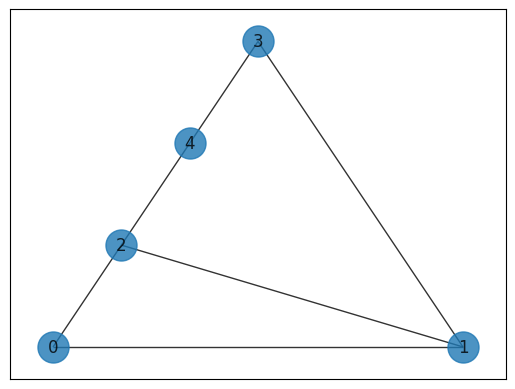

In [12]:
import networkx as nx

# Create graph
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)])
pos = nx.planar_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=True, alpha=0.8, node_size=500)

Constructing a Grover's search algorithm is done in similar to the 3-SAT examples, we only require to define a predicate formula. In this example we set the cut size (the value of $T$) to 4.

In [13]:
CUT_SIZE = 4


# cut formulas
def is_cross_cut_edge(x1: int, x2: int) -> int:
    return x1 * (1 - x2) + x2 * (1 - x1)


def cut(x):
    return sum(is_cross_cut_edge(x[node1], x[node2]) for (node1, node2) in G.edges)


def cut_predicate(cut_size, x):
    return cut(x) >= cut_size

In [14]:
@qfunc
def cut_oracle(cut_size: CInt, nodes: Const[QArray], res: Permutable[QBit]):
    res ^= cut_predicate(cut_size, nodes)


@qfunc
def main(r: CInt, nodes: Output[QArray[len(G.nodes)]]):
    allocate(nodes)
    hadamard_transform(nodes)

    power(
        r,
        lambda: grover_operator(
            lambda vars: phase_oracle(
                lambda vars, res: cut_oracle(CUT_SIZE, vars, res), vars
            ),
            hadamard_transform,
            nodes,
        ),
    )


qprog_max_cut = synthesize(main, constraints=Constraints(max_width=22))
write_qmod(main, "grover_max_cut")
show(qprog_max_cut)

Quantum program link: https://platform.classiq.io/circuit/32MkkUAvmbTab7ZPIAJkVhl5MxJ


In [15]:
# In this example we reduce the threshold, since typically, more than one solution is expected
res, r = repeat_grover_until_success(
    qprog_max_cut, lambda nodes: cut_predicate(CUT_SIZE, nodes), threshold=0.1
)

running Grover with 1 repetitions
Success! a solution was found with probability larger than 0.1, using 1 repetitions


Upon printing the result, we see that our execution of Grover's algorithm successfully found the satisfying assignments for the input formula:

In [16]:
n_solutions = 32
df = res.dataframe
df_new = df.head(n_solutions).copy()
first_col = df.columns[0]
df_new["f(x)"] = df_new[first_col].apply(lambda x: cut_predicate(CUT_SIZE, x))
df_new

,nodes,count,probability,bitstring,f(x)
0,"[1, 1, 0, 0, 1]",109,0.109,10011,True
1,"[1, 0, 1, 1, 0]",105,0.105,01101,True
2,"[0, 1, 1, 0, 0]",103,0.103,00110,True
3,"[1, 0, 0, 1, 1]",102,0.102,11001,True
4,"[0, 1, 1, 0, 1]",100,0.100,10110,True
5,"[0, 0, 1, 1, 0]",97,0.097,01100,True
6,"[1, 0, 0, 1, 0]",88,0.088,01001,True
7,"[0, 1, 1, 1, 0]",88,0.088,01110,True
8,"[1, 0, 0, 0, 1]",84,0.084,10001,True
9,"[0, 1, 0, 0, 1]",81,0.081,10010,True


The satisfying assignments are ~6 times more probable than the unsatisfying assignments. We print one:

In [17]:
result_parsed = df_new["nodes"][0]

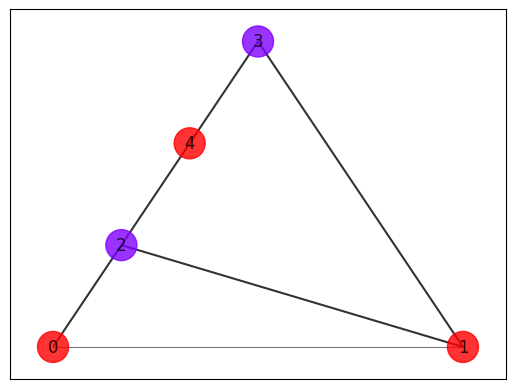

In [18]:
import matplotlib.pyplot as plt

edge_widths = [
    is_cross_cut_edge(
        int(result_parsed[i]),
        int(result_parsed[j]),
    )
    + 0.5
    for i, j in G.edges
]
node_colors = [int(c) for c in result_parsed]
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    alpha=0.8,
    node_size=500,
    node_color=node_colors,
    width=edge_widths,
    cmap=plt.cm.rainbow,
)

<h3 id="references">References</h3>
<ol>
  <li id="ref-Gro96">
    L. K. Grover, “A fast quantum mechanical algorithm for database search”, Proceedings of the 28th Annual ACM Symposium on Theory of Computing (STOC ’96), pp. 212–219, 1996.
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://dl.acm.org/doi/10.1145/237814.237866" target="_blank" rel="noopener noreferrer">DOI &#8599;</a>
    &nbsp;•&nbsp;
    <a href="https://arxiv.org/abs/quant-ph/9605043" target="_blank" rel="noopener noreferrer">arXiv &#8599;</a>
  </li>
  <li id="ref-3SAT">
    The 3-SAT problem
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://en.wikipedia.org/wiki/Boolean_satisfiability_problem#3-satisfiability" target="_blank" rel="noopener noreferrer"> Wikipedia &#8599;</a>
  </li>
    <li id="ref-MaxCutWiki">
    The Maximum Cut problem
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://en.wikipedia.org/wiki/Maximum_cut" target="_blank" rel="noopener noreferrer"> Wikipedia &#8599;</a>
</ol>